In [51]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from datetime import date

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [52]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 20:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [53]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [54]:
BASE_URL = 'https://finance.yahoo.com' #Global Variable 

def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #time
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'url' : BASE_URL + news_url,
            'content' : news_content,
           }

In [55]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [56]:
# url = 'https://finance.yahoo.com/topic/stock-market-news/'
# doc = get_page(url)
# news_list = get_news_tags(doc)
# news_list

## Entire Stock Market News

In [57]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = BASE_URL + '/topic/stock-market-news/'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2022-12-15
Report Time = 14:28:23


In [58]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [59]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [60]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [61]:
news_df[news_df['Score'] > 0.8]

,source,time,headline,url,content,Sentiment,Score,Sentiment2,Score2
0,Bloomberg,6 minutes ago,Dollar Rallies as Risk-Off Tone Takes Stocks Lower: Markets Wrap,https://finance.yahoo.com/news/asian-stocks-open-lower-hawkish-224244888.html,"(Bloomberg) -- Stocks across global financial markets were pummeled after a wave of rate hikes from central banks, with the Federal Reserve and the European Central Bank warning of more pain to come. Most Read from BloombergIs Putin Finally Getting Smart About His Ukraine Disaster?Elon Musk’s Tesla Share Sales Approach the $40 Billion MarkPowell Says Fed Still Has a ‘Ways to Go’ After Half-Point HikeStocks Push Lower as Traders Digest Rate Moves: Markets WrapUS equities hit session lows in t...",NEGATIVE,0.998048,NEGATIVE,0.996891
1,Yahoo Finance,9 minutes ago,"Tesla stock price is largely based on 'hype' and 'pixie dust,' venture capitalist says",https://finance.yahoo.com/news/tesla-stock-price-elon-musk-hype-pixie-dust-191915005.html,One veteran venture capitalize takes Tesla CEO Elon Musk to task with the stock price tanking.,NEGATIVE,0.998896,NEGATIVE,0.989893
2,MarketWatch,10 minutes ago,"Dow skids nearly 900 points, stocks hit session lows in afternoon trade",https://finance.yahoo.com/m/0bae6827-288f-3def-a5e0-0859950a970d/dow-skids-nearly-900-points-.html,"U.S. stocks tumble on Thursday afternoon, adding to the previous day's losses, a day after the Federal Reserve raised rates and revived recession worries.",NEGATIVE,0.995649,NEGATIVE,0.999114
3,MarketWatch,13 minutes ago,"‘Fundamental bottom’ is coming for chips, and this stock could be the biggest winner, analyst says",https://finance.yahoo.com/m/d167ccbe-65ad-39aa-be5e-2c11c559986f/%E2%80%98fundamental-bottom%E2%80%99-is.html,Nvidia Corp. leads top picks for semiconductor stocks heading into 2023 for one noted analyst Thursday.,NEGATIVE,0.999113,NEGATIVE,0.500304
4,MarketWatch,16 minutes ago,‘The Fed is going to overdo it’: Financial markets finally react to U.S. central bank’s 2023 rate outlook and weak data,https://finance.yahoo.com/m/90ce3d1e-c787-37b8-b30d-3200b0f55f67/%E2%80%98the-fed-is-going-to-overdo.html,"Financial markets absorbed the Federal Reserve's stridently hawkish interest-rate outlook for 2023, plus fresh signs of a weakening U.S. economy",NEGATIVE,0.998980,NEGATIVE,0.979441
5,Investor's Business Daily,17 minutes ago,Denbury Stock Joins Rank Of Stocks With RS Ratings Over 90,https://finance.yahoo.com/m/2d791991-ce82-3b5a-810e-b562e2f068a7/denbury-stock-joins-rank-of.html,"Denbury stock had its Relative Strength (RS) Rating upgraded from 89 to 92 Thursday. The oil and gas company also sports a 97 Composite Rating. As you try to find the best stocks to buy and watch, be sure to pay attention to relative price strength.",POSITIVE,0.966802,POSITIVE,0.841385
6,Investor's Business Daily,28 minutes ago,Macy's Stock Showing Rising Market Leadership; Earns 83 RS Rating,https://finance.yahoo.com/m/e3abb954-311c-375c-8b49-e6c0cf3ac7e8/macy-s-stock-showing-rising.html,"On Thursday, Macy's stock earned an upgrade to its Relative Strength (RS) Rating, from 78 to 83. When you're researching the best stocks to buy and watch, keep a close on eye on relative price strength.",POSITIVE,0.996933,POSITIVE,0.997975
7,CoinDesk,32 minutes ago,Web3 Infrastructure Firm Blocknative Raises $15M for Ethereum Block Building Market,https://finance.yahoo.com/news/web3-infrastructure-firm-blocknative-raises-185617795.html,"The funding round was led by Blockchain Capital, Foundry Group and several other venture capital firms.",NEGATIVE,0.984750,NEGATIVE,0.952129
8,Investor's Business Daily,33 minutes ago,"Two Casino Stocks Stand Out As Inflation Hedges, Las Vegas Plays",https://finance.yahoo.com/m/67a1db87-7547-3b93-98dd-679d28cd85fb/two-casino-stocks-stand-out.html,"Casino stocks could offer flight-to-safety inflation hedges, as odd as it sounds. Both are benefiting from a rebound in Las Vegas visits and beneficial inflation clauses in their lease 

### Sentiment of Headline

Text(0.5, 1.0, 'Sentiment of Headline')

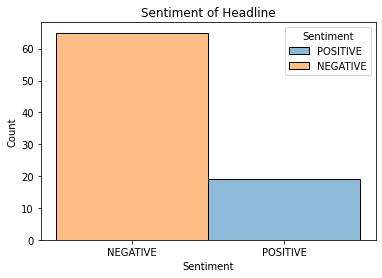

In [62]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Headline")

### Sentiment of Content

Text(0.5, 1.0, 'Sentiment of Content')

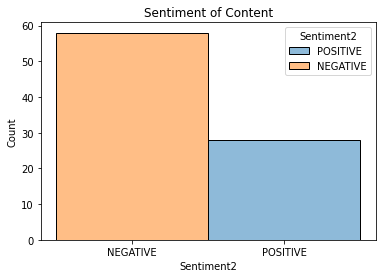

In [63]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Content")

In [64]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [65]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)


## Each Articles

In [66]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [67]:
url = "https://finviz.com/news.ashx"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    project_href = [i['href'] for i in soup.find_all('a', href=True)]

    for tag in soup.find_all('a', href=True):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [68]:
df = pd.DataFrame(sentence2)

In [69]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])
df['Links'] = project_href

In [70]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [71]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [72]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [74]:
df.head(2)

,Headline,Sentiment,Links,word_count,Score,Headline_Lower
17,"Over 30K Good Matters candles recalled for burning at 'higher than usual temperatures,' causing fire hazard",NEGATIVE,https://foxbusiness.com/retail/over-30k-good-matters-candles-recalled-burning-higher-than-usual-temperatures-causing-fire-hazard,16,0.990682,"over 30k good matters candles recalled for burning at 'higher than usual temperatures,' causing fire hazard"
19,Stocks are in a big hole as hawkishness by central banks fuels recession fears,NEGATIVE,https://www.marketwatch.com/livecoverage/dow-futures-sink-over-250-points-over-fed-decision,14,0.998800,stocks are in a big hole as hawkishness by central banks fuels recession fears


In [80]:
summary_pipeline = pipeline("summarization", model="pszemraj/long-t5-tglobal-base-16384-book-summary")

In [82]:
headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}


for url in df['Links']: 
    req = Request(url, headers=headers)

    try:
        contents = urlopen(req).read() 
        soup = BeautifulSoup(contents, features="html.parser")

        sentence2 = []

        for tag in soup.find_all('p'):

            sentence = tag.text.split(".")
            sentence2.append(sentence)

        summary_pipeline = pipeline("summarization", model="pszemraj/long-t5-tglobal-base-16384-book-summary")

        summary = [None] * len(df)
        #sentiment_score = [None] * len(news_df)
        index = -1
        for sentence in sentence2:
            index+=1
            result = summary_pipeline(sentence[:512])[0]
            summary[index] = result['label']
            #sentiment_score[index] = result['score']
        df['Summary'] = summary
        #news_df['Score'] = sentiment_score

    except urllib.error.HTTPError as err:
        print(err.code)

    except socket.timeout as se:
        print("socket timeout")

Your max_length is set to 512, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
